# Tronos analysis
## Introduction
Welcome to Tronos Analysis. In this notebook, analysis of single-cell chromosome trajectories is possible, as performed during meiosis in fission yeast to assay horsetail oscillations. There are two types of cells; _markdown_ cells such as this, with text content containing explanations about the analysis methodology and interpretation of results, and _code_ cells, which contains the snippets that may be executed with your own data.

Refer to the latest up-to-date Notebooks at https://github.com/danilexn/tronos

Please, cite this repository and the paper when using the Tronos workflow

## Configuring parameters
In the following cell, you may want to configure some settings that will be used throughout the rest of the analysis, such as Pixel Sizel, Moving Average smoothing order and the sampling time, in seconds.

Please, give the data in the Tronos-output format, i.e. CSV, with the following columns (any order is possible):

_frame, y, x, minor, major, area, convexity, perimeter, circularity_

In [1]:
pixel.size <- 0.066 # Microns (indicate 1 if already set in source file)
ma.order <- 12
sampling.time <- 60 # Seconds
file.route <- "/mnt/c/Users/admincabd/Desktop/AlbertoPS/Aprendiendo/Tronitos/Sabas/resultados/TL1_sabas_AFA854_4_R3D_PRJ_trajs.csv" # CSV file route

## Loading data

The time variable is specified after the df\\$times <- [], where [] is the variable in df\\$variable format that represents time, in seconds. Please, re-scale your variable to represent seconds.

You may also specify a timepoint 0 different from frame 1 with feature-linking. Please, refer to the instructions in https://github.com/danilexn/tronos

In [2]:
## Reading the file and configuring pixel size
df <- read.csv(file.route)

## SETUP TIME
df$times <- df$frame

## Configure the time variable
df$x <- (df$x - min(df$x))*pixel.size
df$y <- (df$y - min(df$y))*pixel.size
df[,c("minor","major","area")] <- df[,c("minor","major","area")]*pixel.size
df$radius <- sqrt(df$area/3.14)

## Preconfiguring a default axis in case rotation is not performed
y <- df$y

## Rotating cell coordinates
As the cells may be oriented in different angles, a critical step of oscillation analysis is to homogeneize axis across cells, making measures comparable. In the following cell, the best rotation is calculated to make the Y axis the greatest varying, and X the lesser varying. If you exclude to analyze this cell, please consider that the trajectory is going to be considered as the source Y axis, without rotation.

In [3]:
library(spdep)

coords <- cbind(X = df$x, Y = df$y)
rad <- seq(0, pi, l=20)
opar <- par(mfrow=c(5,4), mar=c(3,3,1,1))
best.rotation <- c()
for(i in rad){
    coords.rot <- Rotation(coords, i)
    best.rotation <- c(best.rotation, abs(max(coords.rot[,1])-min(coords.rot[,1])))
}

rot <- rad[which.min(best.rotation)]
coords.rot <- Rotation(coords, rot)
y <- coords.rot[,2]

Loading required package: sp

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 7.0.0



## Sequence spectrum
There are two domains that can be considered in this analysis: time domain, as the change in position over time, and frequency domain, as the richness of frequencies of this behaviour; in summary, frequential-spectral analysis allows to assay the composition of periodicities or frequencies of a given time series, as a measure of how it can be repetitive or oscillatory. Spectral density, represented in the Trajectory periodicity plot below, may present peaks around the frequencies that arise from the change in position over time. As an example, a frequency of 2.7e-03 Hz or a period of around 6 minutes indicates that the trajectory is repetitive in 6 minutes intervals. Presence of various peaks may indicate that there are different periodicities at the same time, or that in the same time series, there is first a dominant frequency, then other dominant frequency (maybe to a conservation in movement amplitude but with different velocity).

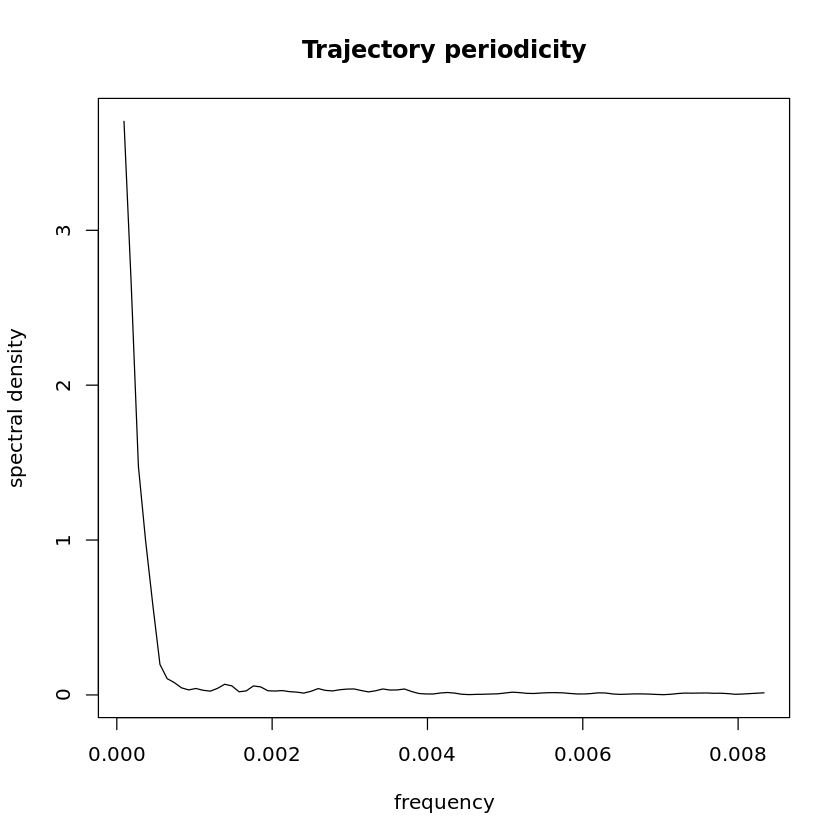

In [4]:
# Calculate the global spectrum and plot
y.spec <- spectrum(y,log="yes",span=2,plot=FALSE)

# Axis readjustment
spx <- y.spec$freq/sampling.time
spy <- 2*y.spec$spec
plot(spy~spx,main="Trajectory periodicity", xlab="frequency",ylab="spectral density",type="l")

## Velocity calculation
Velocity is calculated as the vector modulo, for the X and Y positions specified in the source files. This way, speed is invariant on the previous rotation. A moving average smoothing can also take place: this method allows to reduce extreme peaks or variation in a univariate time series, hence allowing to perform the following analysis more easily (i.e., segmentation analysis).

In [ ]:
vt <- diff(df$x)^2+diff(df$y)^2
vt.smooth <- forecast::ma(vt, order = ma.order)

plot(vt, main="Chromosome velocity (in microns)", ylab = "Velocity")
lines(vt.smooth)

## Morphologies 
The following plots represent the most interesting morphological descriptors, being convexity, circularity, major axis and minor axis. This way, it can be visualized how different segments can comprise the nuclear oscillations, and how different morphology classes can be considered.

In [ ]:
# Distributions for the morphologies
par(mfrow = c(2,2))
plot(density(df$convexity), main = "Convexity")
plot(density(df$circularity), main = "Circularity")
plot(density(df$major), main = "Major axis")
plot(density(df$minor), main = "Minor axis")

## Time series segmentation
Thanks to the segclust2d library, segmentation of the trajectory and convexity is possible, at once. This segmentation means that the lapse of nuclear oscillations is composed of different moments, and the conservation and distribution of these segments may give an idea of the possible biological meaning of each. This number of segments is selected after the best Likelihood explained by the Lavielle criterium.

In [ ]:
# Segmentation according to velocity and convexity; position and convexity
library(segclust2d)

convertTS <- function(Y, X) {
    df_seg <- data.frame(y=Y, x=X)
    return(df_seg[complete.cases(df_seg), ])
}

seg.velocity.convexity <- segmentation(convertTS(c(vt, 0), df$convexity), lmin = 5, Kmax = 20, seg.var = c("y", "x"))
seg.position.convexity <- segmentation(convertTS(y, df$convexity), lmin = 5, Kmax = 20, seg.var = c("y", "x"))

# Best case durations of each segment
segments <- seg.velocity.convexity
seg.2 <- segments$outputs$`2 segments`$segments
durations.seg.2 <- seg.2$end - seg.2$begin
seg.3 <- segments$outputs$`3 segments`$segments
durations.seg.3 <- seg.3$end - seg.3$begin
seg.4 <- segments$outputs$`4 segments`$segments
durations.seg.4 <- seg.4$end - seg.4$begin
seg.5 <- segments$outputs$`5 segments`$segments
durations.seg.5 <- seg.5$end - seg.5$begin
seg.6 <- segments$outputs$`6 segments`$segments
durations.seg.6 <- seg.6$end - seg.6$begin

# Plot the segmentation
plot(seg.velocity.convexity)

## Segments and its analysis
After a number of segments is chosen thanks to the Lavielle criterium, you would want to specify which has been the preferred selection in each case, this way durations of each segment can be extrapolated for following analysis (i.e. durations in different conditions). 

An spectrogram (frequencies versus time) along with the lines in segments will be represented, to accound for a visual representation of the significance of the previous segmentation. It can be observed, in the example case, how the velocity and convexity segmentation yielded a segment configuration that is compatible with changes in the significance level of the spectrogram; hence, it may be confirmed how the segments also have different underlying periodicities or frequencies, that are different from a random walk sequence, as first observed in the spectral density plot.

In [ ]:
library(dplR)
specCols <- c("#5E4FA2", "#3288BD", "#66C2A5", "#ABDDA4", "#E6F598", 
              "#FEE08B", "#FDAE61", "#F46D43", "#D53E4F", "#9E0142")

best.case <- get(paste0("seg.", segments$Kopt.lavielle))

wave.out <- morlet(y, 1:length(y), p2 = 8, dj = 0.1, siglvl = 0.999) 

wavelet.plot(wave.out, reverse.y = TRUE, key.cols=specCols)
abline(v=c(best.case$end, best.case$begin), lwd = 1.5, col= c("blue","red"), lty=2)

# Create the spectrogram
pdf(file = "spectrogram_AFA851.pdf",   # The directory you want to save the file in
    width = 4, # The width of the plot in inches
    height = 4) # The height of the plot in inches
wavelet.plot(wave.out, reverse.y = TRUE, key.cols=specCols)
abline(v=c(best.case$end, best.case$begin), lwd = 1.5, col= c("blue","red"), lty=2)
dev.off()

## Motif discovery
Once segments have been discovered, you may want to explain motifs occurring in the time series, and classify different classes respect to chromosome morphology, as observed in the non-Gaussian distribution in the previous density plots. Both tsmp and mclust libraries allow to perform motif discovery and clusterization from chromosome oscillation trajectory and morphology data.

Please, take into account that, for motifs, the result for single-cell analysis may not be significant, as motifs should be regarded from the point of view of the conservation of behaviours across cells. Hence, please take this code snippet and run it with all trajectory information, rotated from a single Y axis, as the output of this notebook. Also, consider if it is neccesary to extract only one segment from each cell (i.e., concatenating all segments with higher velocity to discover common patterns). You may get those segments from the time boundaries in the segmentation object generated in the previous cell.

In [ ]:
library(tsmp)
library(mclust)

# Trajectory motif finding
matrix <- tsmp(y, window_size = 12, s_size = 50, mode = "stomp")
motifs <- find_motif(matrix, n_motifs = 6)
plot(motifs)

# Class algorithm for morphologies
classes <- Mclust(df[,c("convexity", "circularity", "major", "minor")])
plot.Mclust(classes)

## Causality analysis
After segments have been defined, and motifs-classes have been discovered, you may want to explore causation relations between variables. For the following cell, convexity and rotated-Y trajectory are chosen as the two variables of study. You may want to dig into the code, and explore different causality relations, explained with the Granger test.

In [ ]:
library(lmtest)

# Causation calculation
conv_causes_traj <- c()
traj_causes_conv <- c()

traj <- vt.smooth
conv <- forecast::ma(df$convexity, order = 2)

for (i in 1:20){
  conv_causes_traj <- c(conv_causes_traj, grangertest(conv, traj, order = i)$`Pr(>F)`)
  traj_causes_conv <- c(traj_causes_conv, grangertest(traj, conv, order = i)$`Pr(>F)`)
}

par(mfrow = c(2,1))
plot(log(conv_causes_traj[!is.na(conv_causes_traj)]), ylab = "Convexity causes trajectory")
abline(h = log(0.005), col = "Red")
plot(log(traj_causes_conv[!is.na(traj_causes_conv)]), ylab = "Trajectory causes convexity")
abline(h = log(0.005), col = "Red")
par(mfrow = c(1,1))